In [ ]:
# Various RIDC methods mostly focussing on the use of AB correctors and predictors.

In [5]:
import numpy as np
from scipy.interpolate import lagrange
import matplotlib.pyplot as plt

In [6]:
def func(t, y):
    return 4*t*(y)**(0.5)

def y_exact(t):
    return (1 + t**2)**2

In [7]:
def beta(M):
    '''
    Generates beta coefficients for Adam-Bashforth integrating scheme
    These coefficients are stored in reversed compared to conventional
    Adam-Bashforth implementations (the first element of beta corresponds to
    earlier point in time).
    input:
    M: the order of Adam-Bashforth scheme
    '''
    if M == 2:
        return np.array([-1./2, 3./2])
    elif M == 3:
        return np.array([5./12, -16./12, 23./12])
    elif M == 4:
        return np.array([-9./24, 37./24, -59./24, 55./24])
    elif M == 5:
        return np.array([251./720, -1274./720, 2616./720, -2774./720, 1901./720])
    elif M == 6:
        return np.array([-475./720, 2877./720, -7298./720, 9982./720, -7923./720, 4277./720])

In [8]:
# Euler predictors and correctors

def HOSSEINsolver0(func, T, y0, N, M):
    '''
    Inputs:
    ff: the RHS of the system of ODEs y'=f(t,y)
    T:  integration interval[0,T]
    y0: initial condition
    N:  number of nodes
    M: the number of points in calculating quadraure integral
    (and also the number of steps used in Adam-Bashforth predictor)
    or number of correction loops PLUS the prection loop

    Output:
    t: time vector
    yy: solution as a function of time
    '''
    # number of equations in ODE (aka degree of freedom, dimension of space)
    # for now set to 1 (will be modified LATER to handle more than one dime)
    # d = 1  # len(y0)
    # time step
    h = float(T)/N
    d = len(y0)
    # M: the number of points in calculating quadraure integral
    # (and also the number of steps used in Adam-Bashforth predictor)
    # Note Mm is the number of correctors
    Mm = M - 1
    # Forming the quadraure matrix S[m,i]
    S = np.zeros([Mm, Mm+1])
    for m in range(Mm):  # Calculate qudrature weights
        for i in range(Mm+1):
            x = np.arange(Mm+1)  # Construct a polynomial
            y = np.zeros(Mm+1)   # which equals to 1 at i, 0 at other points
            y[i] = 1
            p = lagrange(x, y)
            para = np.array(p)    # Compute its integral
            P = np.zeros(Mm+2)
            for k in range(Mm+1):
                P[k] = para[k]/(Mm+1-k)
            P = np.poly1d(P)
            S[m, i] = P(m+1) - P(m)
    Svec = S[Mm-1, :]
    # the final answer will be stored in yy
    yy = np.zeros([N+1,d])
    # putting the initial condition in y
    yy[0,:] = y0
    # Value of RHS at initial time
    F0 = func(0, y0)
    # the time vector
    t = np.arange(0, T+h, h)
    # extended time vector (temporary: cuz I didn't write code for end part)
    t_ext = np.arange(0, T+h+M*h, h)
    # F vector and matrice:
    # the RHS of ODE is evaluated and stored in this vector and matrix:
    # F1 [M x M]: first index is the order (0=prection, 1=first correction)
    # second index is the time (iTime)
    # Note F1 could have been [M-1 x M] as the first two rows are equal to each
    # other BUT we designed it as a place holder for future parallelisation
    F1 = np.zeros([Mm, M,d])
    F1[:, 0,:] = F0
    F2 = F0
    # Y2 [M] new point derived in each level (prediction and corrections)
    Y2 = np.ones([M,d])*y0
    
    # ================== INITIAL PART (1) ==================
    # for this part the predictor and correctors step up to M points in time
    # ** predictor ** uses Runge-Kutta 4
    for iTime in range(0, M-1):
        KK1 = F1[0, iTime,:]
        KK2 = func(t[iTime]+h/2, Y2[0,:]+KK1*h/2)
        KK3 = func(t[iTime]+h/2, Y2[0,:]+KK2*h/2)
        KK4 = func(t[iTime]+h,   Y2[0,:]+KK3*h)
        Y2[0,:] = Y2[0,:] + h*(KK1 + 2*KK2 + 2*KK3 + KK4)/6
        # Y2[0] = Y2[0] + h*KK1
        F1[0, iTime+1,:] = func(t[iTime+1], Y2[0,:])
    # ** correctors ** use Integral Deffered Correction
    for iCor in range(1, M-1):
        ll = iCor - 1
        for iTime in range(0, M-1):
            Y2[iCor,:] = Y2[iCor,:] + h*(F1[iCor, iTime,:]-F1[ll, iTime,:]) + \
                h * np.dot(S[iTime, :], F1[ll, :,:])
            F1[iCor, iTime+1,:] = func(t[iTime+1], Y2[iCor,:])
    # treat the last correction loop a little different
    for iTime in range(0, M-1):
        Y2[M-1,:] = Y2[M-1,:] + h*(F2-F1[M-2, iTime,:]) + \
            h * np.dot(S[iTime, :], F1[M-2, :,:])
        F2 = func(t[iTime+1], Y2[M-1,:])
        yy[iTime+1,:] = Y2[M-1,:]

    # ================== INITIAL PART (2) ==================
    beta_vec = beta(M)
    for iTime in range(M-1, 2*M-2):
        iStep = iTime - (M-1)
        # prediction loop
        Y2[0,:] = Y2[0,:] + h*np.dot(beta_vec, F1[0, :,:])
        # correction loops
        for ll in range(iStep):
            iCor = ll + 1
            Y2[iCor,:] = Y2[iCor,:] + h*(F1[iCor, -1,:]-F1[ll, -2,:]) + \
                h * np.dot(Svec, F1[ll, :,:])
        F1[0, 0:M-1,:] = F1[0, 1:M,:]
        F1[0, M-1,:] = func(t_ext[iTime+1], Y2[0,:])
        for ll in range(iStep):
            iCor = ll + 1
            F1[iCor, 0:M-1,:] = F1[iCor, 1:M,:]
            F1[iCor, M-1,:] = func(t_ext[iTime+1-iCor], Y2[iCor,:])

    # ================== MAIN LOOP FOR TIME ==================
    for iTime in range(2*M-2, N+M-1):
        # prediction loop
        Y2[0,:] = Y2[0,:] + h*np.dot(beta_vec, F1[0, :,:])
        # correction loops up to the second last one
        for ll in range(M-2):
            iCor = ll + 1
            Y2[iCor,:] = Y2[iCor,:] + h*(F1[iCor, -1,:]-F1[ll, -2,:]) + \
                h * np.dot(Svec, F1[ll, :,:])
        # last correction loop
        Y2[M-1,:] = Y2[M-1,:] + h * (F2-F1[M-2, -2,:]) + \
            h * np.dot(Svec, F1[M-2, :,:])

        # ~~~~~~~~~~~ Updating Stencil ~~~~~~~~~~~
        # ---> updating correctors stencil
        for ll in range(1, M-1):
            F1[ll, 0:M-1,:] = F1[ll, 1:M,:]
            F1[ll, M-1,:] = func(t_ext[iTime+1-ll], Y2[ll,:])
        # storing the final answer
        yy[iTime+1-(M-1),:] = Y2[M-1,:]
        F2 = func(t_ext[iTime+1-(M-1)], Y2[M-1,:])
        # ---> updating predictor stencil
        # ** approach #0:
        F1[0, 0:M-1,:] = F1[0, 1:M,:]
        # ** approach #1: pushing the most correct answer to predictor
        # F1[0, 0] = F2
        # F1[0, 1:M-1] = F1[0, 2:M]
        # ** approach #2 : pushing the recently corrected answer of
        # each corrector to the associated node in predictor
        # F1[0, 0] = F2
        # for ii in range(1, M-1):
        #     F1[0, ii] = F1[-ii, -1]

        F1[0, M-1,:] = func(t_ext[iTime+1], Y2[0,:])

    return t, yy

In [9]:
#Original code

def HOSSEINsolverAB(func, T, y0, N, M):
    '''
    Inputs:
    ff: the RHS of the system of ODEs y'=f(t,y)
    T:  integration interval[0,T]
    y0: initial condition
    N:  number of nodes
    M: the number of points in calculating quadraure integral
    (and also the number of steps used in Adam-Bashforth predictor)
    or number of correction loops PLUS the prection loop
    Output:
    t: time vector
    yy: solution as a function of time
    '''
    # number of equations in ODE (aka degree of freedom, dimension of space)
    # for now set to 1 (will be modified LATER to handle more than one dime)
    # d = 1  # len(y0)
    # time step
    h = float(T)/N
    # M: the number of points in calculating quadraure integral
    # (and also the number of steps used in Adam-Bashforth predictor)
    # Note Mm is the number of correctors
    Mm = M - 1
    # Forming the quadraure matrix S[m,i]
    S = np.zeros([Mm, Mm+1])
    for m in range(Mm):  # Calculate qudrature weights
        for i in range(Mm+1):
            x = np.arange(Mm+1)  # Construct a polynomial
            y = np.zeros(Mm+1)   # which equals to 1 at i, 0 at other points
            y[i] = 1
            p = lagrange(x, y)
            para = np.array(p)    # Compute its integral
            P = np.zeros(Mm+2)
            for k in range(Mm+1):
                P[k] = para[k]/(Mm+1-k)
            P = np.poly1d(P)
            S[m, i] = P(m+1) - P(m)
    Svec = S[Mm-1, :]
    # the final answer will be stored in yy
    yy = np.zeros(N+1)
    # putting the initial condition in y
    yy[0] = y0
    # Value of RHS at initial time
    F0 = func(0, y0)
    # the time vector
    t = np.arange(0, T+h, h)
    # extended time vector (temporary: cuz I didn't write code for end part)
    t_ext = np.arange(0, T+h+M*h, h)
    # F vector and matrice:
    # the RHS of ODE is evaluated and stored in this vector and matrix:
    # F1 [M x M]: first index is the order (0=prection, 1=first correction)
    # second index is the time (iTime)
    # Note F1 could have been [M-1 x M] as the first two rows are equal to each
    # other BUT we designed it as a place holder for future parallelisation
    F1 = np.zeros([Mm, M])
    F1[:, 0] = F0
    F2 = F0
    # Y2 [M] new point derived in each level (prediction and corrections)
    Y2 = np.ones(M)*y0
    # ================== INITIAL PART (1) ==================
    # for this part the predictor and correctors step up to M points in time
    # ** predictor ** uses Runge-Kutta 4
    for iTime in range(0, M-1):
        KK1 = F1[0, iTime]
        KK2 = func(t[iTime]+h/2, Y2[0]+KK1*h/2)
        KK3 = func(t[iTime]+h/2, Y2[0]+KK2*h/2)
        KK4 = func(t[iTime]+h,   Y2[0]+KK3*h)
        Y2[0] = Y2[0] + h*(KK1 + 2*KK2 + 2*KK3 + KK4)/6
        # Y2[0] = Y2[0] + h*KK1
        F1[0, iTime+1] = func(t[iTime+1], Y2[0])
    # ** correctors ** use Integral Deffered Correction
    for iCor in range(1, M-1):
        ll = iCor - 1
        for iTime in range(0, M-1):
            Y2[iCor] = Y2[iCor] + h*(F1[iCor, iTime]-F1[ll, iTime]) + \
                h * np.dot(S[iTime, :], F1[ll, :])
            F1[iCor, iTime+1] = func(t[iTime+1], Y2[iCor])
    # treat the last correction loop a little different
    for iTime in range(0, M-1):
        Y2[M-1] = Y2[M-1] + h*(F2-F1[M-2, iTime]) + \
            h * np.dot(S[iTime, :], F1[M-2, :])
        F2 = func(t[iTime+1], Y2[M-1])
        yy[iTime+1] = Y2[M-1]

    # ================== INITIAL PART (2) ==================
    beta_vec = beta(M)
    beta_vec2 = beta(M-1)
    for iTime in range(M-1, 2*M-2):
        iStep = iTime - (M-1)
        # prediction loop
        Y2[0] = Y2[0] + h*np.dot(beta_vec, F1[0, :])
        # correction loops
        for ll in range(iStep):
            iCor = ll + 1
            Y2[iCor] = Y2[iCor] + h*(F1[iCor, -1]-F1[ll, -2]) + \
                h * np.dot(Svec, F1[ll, :])
        F1[0, 0: M-1] = F1[0, 1: M]
        F1[0, M-1] = func(t_ext[iTime+1], Y2[0])
        for ll in range(iStep):
            iCor = ll + 1
            F1[iCor, 0: M-1] = F1[iCor, 1: M]
            F1[iCor, M-1] = func(t_ext[iTime+1-iCor], Y2[iCor])

    # ================== MAIN LOOP FOR TIME ==================
    for iTime in range(2*M-2, N+M-1):
        # prediction loop
        Y2[0] = Y2[0] + h*np.dot(beta_vec, F1[0, :])
        # correction loops up to the second last one
        for ll in range(M-2):
            iCor = ll + 1
            # Y2[iCor] = Y2[iCor] + h*(F1[iCor, -1]-F1[ll, -2]) + \
            #    h * np.dot(Svec, F1[ll, :])
            Fvec = np.array([F1[iCor, -3]-F1[ll, -4], F1[iCor, -2] -
                             F1[ll, -3], F1[iCor, -1]-F1[ll, -2]])
            Y2[iCor] = Y2[iCor] + h*np.dot(beta_vec2, Fvec) + \
                h * np.dot(Svec, F1[ll, :])
        # last correction loop
        F2m = func(t_ext[iTime+1-(M-1)-2], yy[iTime+1-(M-1)-2])
        F2mm = func(t_ext[iTime+1-(M-1)-3], yy[iTime+1-(M-1)-3])
        Fvec = np.array([F2mm-F1[M-2, -4], F2m-F1[M-2, -3], F2-F1[M-2, -2]])
        Y2[M-1] = Y2[M-1] + h*np.dot(beta_vec2, Fvec) + \
            h * np.dot(Svec, F1[M-2, :])

        # ~~~~~~~~~~~ Updating Stencil ~~~~~~~~~~~
        # ---> updating correctors stencil
        for ll in range(1, M-1):
            F1[ll, 0: M-1] = F1[ll, 1: M]
            F1[ll, M-1] = func(t_ext[iTime+1-ll], Y2[ll])
        # storing the final answer
        yy[iTime+1-(M-1)] = Y2[M-1]
        F2 = func(t_ext[iTime+1-(M-1)], Y2[M-1])
        # ---> updating predictor stencil
        # ** approach #0:
        F1[0, 0: M-1] = F1[0, 1: M]
        # ** approach #1: pushing the most correct answer to predictor
        # F1[0, 0] = F2
        # F1[0, 1:M-1] = F1[0, 2:M]
        # ** approach #2 : pushing the recently corrected answer of
        # each corrector to the associated node in predictor
        # F1[0, 0] = F2
        # for ii in range(1, M-1):
        #     F1[0, ii] = F1[-ii, -1]

        F1[0, M-1] = func(t_ext[iTime+1], Y2[0])

    return t, yy




In [11]:
#RK8 start-up able to take different values of M

def HOSSEINsolverAB2(func, T, y0, N, M):
    '''
    Inputs:
    func: the RHS of the system of ODEs y'=f(t,y)
    T:  integration interval[0,T]
    y0: initial condition
    N:  number of nodes
    M: the number of points in calculating quadraure integral
    (and also the number of steps used in Adam-Bashforth predictor)
    or number of correction loops PLUS the prection loop
    
    Output:
    t: time vector
    yy: solution as a function of time
    '''
    # number of equations in ODE (aka degree of freedom, dimension of space)
    # for now set to 1 (will be modified LATER to handle more than one dime)
    # d = 1  # len(y0)
    # time step
    h = float(T)/N
    # M: the number of points in calculating quadraure integral
    # (and also the number of steps used in Adam-Bashforth predictor)
    # Note Mm is the number of correctors
    Mm = M - 1
    # Forming the quadraure matrix S[m,i]
    S = np.zeros([Mm, Mm+1])
    for m in range(Mm):  # Calculate qudrature weights
        for i in range(Mm+1):
            x = np.arange(Mm+1)  # Construct a polynomial
            y = np.zeros(Mm+1)   # which equals to 1 at i, 0 at other points
            y[i] = 1
            p = lagrange(x, y)
            para = np.array(p)    # Compute its integral
            P = np.zeros(Mm+2)
            for k in range(Mm+1):
                P[k] = para[k]/(Mm+1-k)
            P = np.poly1d(P)
            S[m, i] = P(m+1) - P(m)
    Svec = S[Mm-1, :]
    # the final answer will be stored in yy
    yy = np.zeros(N+1)
    # putting the initial condition in y
    yy[0] = y0
    # Value of RHS at initial time
    F0 = func(0, y0)
    # the time vector
    t = np.arange(0, T+h, h)
    # extended time vector (temporary: cuz I didn't write code for end part)
    t_ext = np.arange(0, T+h+M*h, h)
    # F vector and matrice:
    # the RHS of ODE is evaluated and stored in this vector and matrix:
    # F1 [M x M]: first index is the order (0=prection, 1=first correction)
    # second index is the time (iTime)
    # Note F1 could have been [M-1 x M] as the first two rows are equal to each
    # other BUT we designed it as a place holder for future parallelisation
    F1 = np.zeros([Mm, M])
    F1[:, 0] = F0
    F2 = F0
    # Y2 [M] new point derived in each level (prediction and corrections)
    Y2 = np.ones(M)*y0
    # ================== INITIAL PART (1) ==================
    # for this part the predictor and correctors step up to M points in time
    # ** predictor ** uses Runge-Kutta 8
    
 
    for iTime in range(0, M-1):
        
        k_1 = F1[0, iTime]
        k_2 = func(t[iTime]+h*(4/27),Y2[0]+(h*4/27)*k_1 )
        k_3 = func(t[iTime]+h*(2/9) ,Y2[0]+  (h/18)*(k_1+3*k_2))
        k_4 = func(t[iTime]+h*(1/3) ,Y2[0]+  (h/12)*(k_1+3*k_3))
        k_5 = func(t[iTime]+h*(1/2) ,Y2[0]+   (h/8)*(k_1+3*k_4))
        k_6 = func(t[iTime]+h*(2/3) ,Y2[0]+  (h/54)*(13*k_1-27*k_3+42*k_4+8*k_5))
        k_7 = func(t[iTime]+h*(1/6) ,Y2[0]+(h/4320)*(389*k_1-54*k_3+966*k_4-824*k_5+243*k_6))
        k_8 = func(t[iTime]+h       ,Y2[0]+  (h/20)*(-234*k_1+81*k_3-1164*k_4+656*k_5-122*k_6+800*k_7) )
        k_9 = func(t[iTime]+h*(5/6) ,Y2[0]+ (h/288)*(-127*k_1+18*k_3-678*k_4+456*k_5-9*k_6+576*k_7+4*k_8)  )
        k_10= func(t[iTime]+h       ,Y2[0]+(h/820)*(1481*k_1-81*k_3+7104*k_4-3376*k_5+72*k_6-5040*k_7-60*k_8+720*k_9))
        Y2[0] = Y2[0] + h/840*(41*k_1+27*k_4+272*k_5+27*k_6+216*k_7+216*k_9+41*k_10)
        
        

        F1[0, iTime+1] = func(t[iTime+1], Y2[0])
    # ** correctors ** use Integral Deffered Correction
    for iCor in range(1, M-1):
        ll = iCor - 1
        for iTime in range(0, M-1):
            Y2[iCor] = Y2[iCor] + h*(F1[iCor, iTime]-F1[ll, iTime]) + \
                h * np.dot(S[iTime, :], F1[ll, :])
            F1[iCor, iTime+1] = func(t[iTime+1], Y2[iCor])
    # treat the last correction loop a little different
    for iTime in range(0, M-1):
        Y2[M-1] = Y2[M-1] + h*(F2-F1[M-2, iTime]) + \
            h * np.dot(S[iTime, :], F1[M-2, :])
        F2 = func(t[iTime+1], Y2[M-1])
        yy[iTime+1] = Y2[M-1]

    # ================== INITIAL PART (2) ==================
    beta_vec = beta(4)
    beta_vec2 = beta(3)
    for iTime in range(M-1, 2*M-2):
        iStep = iTime - (M-1)
        # prediction loop
        Y2[0] = Y2[0] + h*np.dot(beta_vec, F1[0, -4:])
        # correction loops
        for ll in range(iStep):
            iCor = ll + 1
            Y2[iCor] = Y2[iCor] + h*(F1[iCor, -1]-F1[ll, -2]) + \
                h * np.dot(Svec, F1[ll, :])
        F1[0, 0: M-1] = F1[0, 1: M]
        F1[0, M-1] = func(t_ext[iTime+1], Y2[0])
        for ll in range(iStep):
            iCor = ll + 1
            F1[iCor, 0: M-1] = F1[iCor, 1: M]
            F1[iCor, M-1] = func(t_ext[iTime+1-iCor], Y2[iCor])

    # ================== MAIN LOOP FOR TIME ==================
    for iTime in range(2*M-2, N+M-1):
        # prediction loop
        Y2[0] = Y2[0] + h*np.dot(beta_vec, F1[0, -4:])
        # correction loops up to the second last one
        for ll in range(M-2):
            iCor = ll + 1
            # Y2[iCor] = Y2[iCor] + h*(F1[iCor, -1]-F1[ll, -2]) + \
            #    h * np.dot(Svec, F1[ll, :])
            Fvec = np.array([F1[iCor, -3]-F1[ll, -4], F1[iCor, -2] -
                             F1[ll, -3], F1[iCor, -1]-F1[ll, -2]])
            Y2[iCor] = Y2[iCor] + h*np.dot(beta_vec2, Fvec) + \
                h * np.dot(Svec, F1[ll, :])
        # last correction loop
        F2m = func(t_ext[iTime+1-(M-1)-2], yy[iTime+1-(M-1)-2])
        F2mm = func(t_ext[iTime+1-(M-1)-3], yy[iTime+1-(M-1)-3])
        Fvec = np.array([F2mm-F1[M-2, -4], F2m-F1[M-2, -3], F2-F1[M-2, -2]])
        Y2[M-1] = Y2[M-1] + h*np.dot(beta_vec2, Fvec) + \
            h * np.dot(Svec, F1[M-2, :])

        # ~~~~~~~~~~~ Updating Stencil ~~~~~~~~~~~
        # ---> updating correctors stencil
        for ll in range(1, M-1):
            F1[ll, 0: M-1] = F1[ll, 1: M]
            F1[ll, M-1] = func(t_ext[iTime+1-ll], Y2[ll])
        # storing the final answer
        yy[iTime+1-(M-1)] = Y2[M-1]
        F2 = func(t_ext[iTime+1-(M-1)], Y2[M-1])
        # ---> updating predictor stencil
        # ** approach #0:
        F1[0, 0: M-1] = F1[0, 1: M]
        # ** approach #1: pushing the most correct answer to predictor
        # F1[0, 0] = F2
        # F1[0, 1:M-1] = F1[0, 2:M]
        # ** approach #2 : pushing the recently corrected answer of
        # each corrector to the associated node in predictor
        # F1[0, 0] = F2
        # for ii in range(1, M-1):
        #     F1[0, ii] = F1[-ii, -1]

        F1[0, M-1] = func(t_ext[iTime+1], Y2[0])

    return t, yy


In [19]:

# AB RIDC M=4
errorlist3 = []
stepsizelist3 = []

for i in [5,6,7,8,9,10,15,20,25,30,35,40,45,50,75,100,125,150]:   
    T = np.linspace(0, 2, i+1)
    K2 = HOSSEINsolverAB(func, 2, np.array([1.0]), i, 4)
    stepsizelist3.append(1/(i))
    m = [abs(K2[1][j] - y_exact(T[j])) for j in range(i)]
    errorlist3.append(max(m))

    
#Euler RIDC M=4
errorlist2 = []
stepsizelist2 = []

for i in [5,6,7,8,9,10,15,20,25,30,35,40,45,50,75,100,125,150]:   
    T = np.linspace(0, 2, i+1)
    K2 = HOSSEINsolver0(func, 2, np.array([1.0]), i, 4)
    stepsizelist2.append(1/(i))
    m = [abs(K2[1][j] - y_exact(T[j])) for j in range(i)]
    errorlist2.append(max(m))

# RK start-up M=4
errorlist4 = []
stepsizelist4 = []


for i in [5,6,7,8,9,10,15,20,21,23,25,27,29,30,35,40,45,50,75,100,125,150]:   
    T = np.linspace(0, 2, i+1)
    K2 = HOSSEINsolverAB2(func, 2, np.array([1.0]), i, 4)
    stepsizelist4.append(1/(i))
    m = [abs(K2[1][j] - y_exact(T[j])) for j in range(i)]
    errorlist4.append(max(m))

# RK start-up M=5
errorlist5 = []
stepsizelist5 = []


for i in [5,6,7,8,9,10,15,20,21,23,25,27,29,30,35,40,45,50,75,100,125,150]:   
    T = np.linspace(0, 2, i+1)
    K2 = HOSSEINsolverAB2(func, 2, np.array([1.0]), i, 5)
    stepsizelist5.append(1/(i))
    m = [abs(K2[1][j] - y_exact(T[j])) for j in range(i)]
    errorlist5.append(max(m))


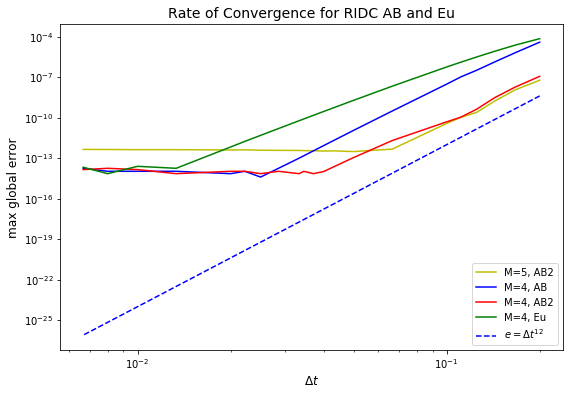

In [21]:
test1 = [i**12 for i in stepsizelist5]
test2 = [i**8 for i in stepsizelist3]

fig, ax = plt.subplots(1, 1, figsize=(9, 6))

plt.plot(stepsizelist5, errorlist5, 'y-', markersize=2, label = 'M=5, AB2')
plt.plot(stepsizelist3, errorlist3, 'b-', markersize=2, label = 'M=4, AB')
plt.plot(stepsizelist4, errorlist4, 'r-', markersize=2, label = 'M=4, AB2')
plt.plot(stepsizelist2, errorlist2, 'g-', markersize=2, label = 'M=4, Eu')
plt.plot(stepsizelist5, test1,'b--',markersize=2,label = '$e = \Delta t^{12}$ ' )

ax.set_xscale('log')
ax.set_yscale('log')
plt.legend(loc="lower right") 
plt.xlabel('$\Delta t$',fontsize = 12)
plt.ylabel(r'max global error',fontsize = 12)
plt.title('Rate of Convergence for RIDC AB and Eu',fontsize = 14)
plt.savefig('RIDCABorder.png')
plt.show()